In [166]:
# 라이브러리 불러오기
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms
import torchaudio
import pandas as pd
import torch
import torch.nn as nn

In [167]:
import torch
import subprocess

def GPU():
    if torch.cuda.is_available() == True:
        device = 'cuda'
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working : ", end="")
        print(templist.is_cuda)
        print("current device no. : ", end="")
        print(torch.cuda.current_device())
        print("GPU device count : ", end="")
        print(torch.cuda.device_count())
        print("GPU name : ", end="")
        print(torch.cuda.get_device_name(0))
        print("device : ", device)
        # Execute the nvidia-smi command using subprocess
        try:
            output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
            print("nvidia-smi output:")
            print(output)
        except (subprocess.CalledProcessError, FileNotFoundError) as e:
            print("Error executing nvidia-smi command:", str(e))
    elif torch.backends.mps.is_available() == True:
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("cant use gpu , activating cpu")
        device = 'cpu'

    return device
device = GPU()
print(device)

Apple device detected
Activating Apple Silicon GPU
mps


In [168]:
# To use 3 channel Resnet
class MonoToColor(nn.Module):
    def __init__(self, num_channels=3):
        super(MonoToColor, self).__init__()
        self.num_channels = num_channels

    def forward(self, tensor):
        return tensor.repeat(self.num_channels, 1, 1)

In [169]:
# Dataset 클래스 정의
import os
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset

class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        
        # Directly assign class IDs without filtering on selected labels
        self.annotations['classID'] = self.annotations['class'].astype('category').cat.codes

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, torch.tensor(label, dtype=torch.long)

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.target_sample_rate:
            signal = signal[:, :self.target_sample_rate]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.target_sample_rate:
            num_missing_samples = self.target_sample_rate - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = self.annotations.iloc[index, 5]
        file_name = self.annotations.iloc[index, 0]
        audio_sample_path = os.path.join(self.audio_dir, fold, file_name)
        return audio_sample_path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [170]:
# 데이터셋 및 데이터 로더 설정
import pandas as pd


# Load the dataset
ANNOTATIONS_FILE = 'dataset2/data2.csv'
temp_csv = pd.read_csv('dataset2/data2.csv')
temp_csv.head(3)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,children_cut_0000.wav,137437,2091.059796,2093.059796,1,children,0,children
1,children_cut_0001.wav,478182,3504.802993,3506.802993,1,children,0,children
2,children_cut_0002.wav,228998,3660.419206,3662.419206,1,children,0,children


In [171]:
import pandas as pd

# Assuming you have the ANNOTATIONS_FILE dataframe
# You can use the value_counts() function on the 'class' column
label_counts = temp_csv['class'].value_counts()

# Display the counts of files for each label in a tabular format
print(label_counts)

children        100
nothing2        100
drilling        100
engine          100
siren           100
gunshot         100
aircon          100
jackhammer      100
carhorn         100
glass           100
nock            100
street_music    100
dog_bark        100
nothing1        100
Name: class, dtype: int64


In [172]:
random = 1 # 1== random,  0 == fix seed

if random == 0:
    import random
    import numpy as np

    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [173]:
AUDIO_DIR = 'dataset2'

In [174]:
SAMPLE_RATE = 22050
BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False

In [175]:
class MinMaxNormalize(nn.Module):
    def __init__(self, min_val=None, max_val=None):
        super(MinMaxNormalize, self).__init__()
        self.min_val = min_val
        self.max_val = max_val

    def forward(self, tensor):
        if self.min_val is None or self.max_val is None:
            min_val = torch.min(tensor)
            max_val = torch.max(tensor)
        else:
            min_val = self.min_val
            max_val = self.max_val
        
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
        return normalized_tensor

In [176]:
transformation = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=40),# higher the better but more complex. For talking we use 128, for sound effect, about 40.
    torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80),
    MinMaxNormalize(),
    MonoToColor()
])

In [177]:
usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, transformation, SAMPLE_RATE)

In [178]:
# 데이터셋 분리
dataset_size = len(usd)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(usd, [train_size, val_size, test_size])

# 데이터 로더 생성
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)


In [179]:
ANNOTATIONS_FILE

'dataset2/data2.csv'

In [180]:
usd

In [181]:
num_labels = len(usd.annotations['classID'].unique())
num_labels

14

In [182]:
# ResNet18 모델 설정
model = resnet18(pretrained=False)
# Change the output neurons of the model
model.fc = nn.Linear(512,num_labels) 
# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
model = model.to(device)

/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [183]:
# 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [184]:
# 학습률 스케줄러 설정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train func 1 (has phase train, val)

# Train func 2 (more normal)

In [185]:
def train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    global best_acc
    global train_loss_list, val_loss_list, train_acc_list, val_acc_list
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    best_acc = 0.0
    best_model_counter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss_train = 0.0
        running_corrects_train = 0

        for inputs, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss_train += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss_train = running_loss_train / dataset_sizes['train']
        epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        # Append to the train lists
        train_loss_list.append(epoch_loss_train)
        train_acc_list.append(epoch_acc_train.item())

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_loss_val = 0.0
        running_corrects_val = 0

        for inputs, labels in tqdm(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val / dataset_sizes['val']
        epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        # Append to the validation lists
        val_loss_list.append(epoch_loss_val)
        val_acc_list.append(epoch_acc_val.item())

        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_counter += 1
            formatted_counter = str(best_model_counter).zfill(3)
            model_save_path = os.path.join("models", f"Model2_{formatted_counter}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f'Best model saved at {model_save_path}')

    print('Best Validation Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# This is the updated function
train_model2

<function __main__.train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs)>

In [186]:
import copy
nb_epochs = 5
# 모델 훈련 시작
dataloaders = {"train": train_loader, "val": val_loader}
# define dataset_sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

best_model = train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs=nb_epochs)

Epoch 1/5
----------


100%|██████████| 70/70 [00:10<00:00,  6.64it/s]


Train Loss: 1.5762 Acc: 0.5000


100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


Validation Loss: 1.3701 Acc: 0.5429
Best model saved at models/Model2_001.pth
Epoch 2/5
----------


100%|██████████| 70/70 [00:08<00:00,  7.92it/s]


Train Loss: 1.1784 Acc: 0.6018


100%|██████████| 9/9 [00:00<00:00, 11.98it/s]


Validation Loss: 1.5218 Acc: 0.5214
Epoch 3/5
----------


100%|██████████| 70/70 [00:07<00:00,  8.82it/s]


Train Loss: 0.9842 Acc: 0.6679


100%|██████████| 9/9 [00:00<00:00, 16.47it/s]


Validation Loss: 1.5705 Acc: 0.4714
Epoch 4/5
----------


100%|██████████| 70/70 [00:07<00:00,  9.43it/s]


Train Loss: 0.7959 Acc: 0.7304


100%|██████████| 9/9 [00:00<00:00, 19.65it/s]


Validation Loss: 1.0594 Acc: 0.6214
Best model saved at models/Model2_002.pth
Epoch 5/5
----------


100%|██████████| 70/70 [00:07<00:00,  9.25it/s]


Train Loss: 0.7265 Acc: 0.7705


100%|██████████| 9/9 [00:00<00:00, 22.96it/s]


Validation Loss: 0.8621 Acc: 0.7286
Best model saved at models/Model2_003.pth
Best Validation Acc: 0.728571


In [187]:
train_acc_list = torch.tensor(train_acc_list).detach().cpu()

In [188]:
val_acc_list = torch.tensor(val_acc_list).detach().cpu()

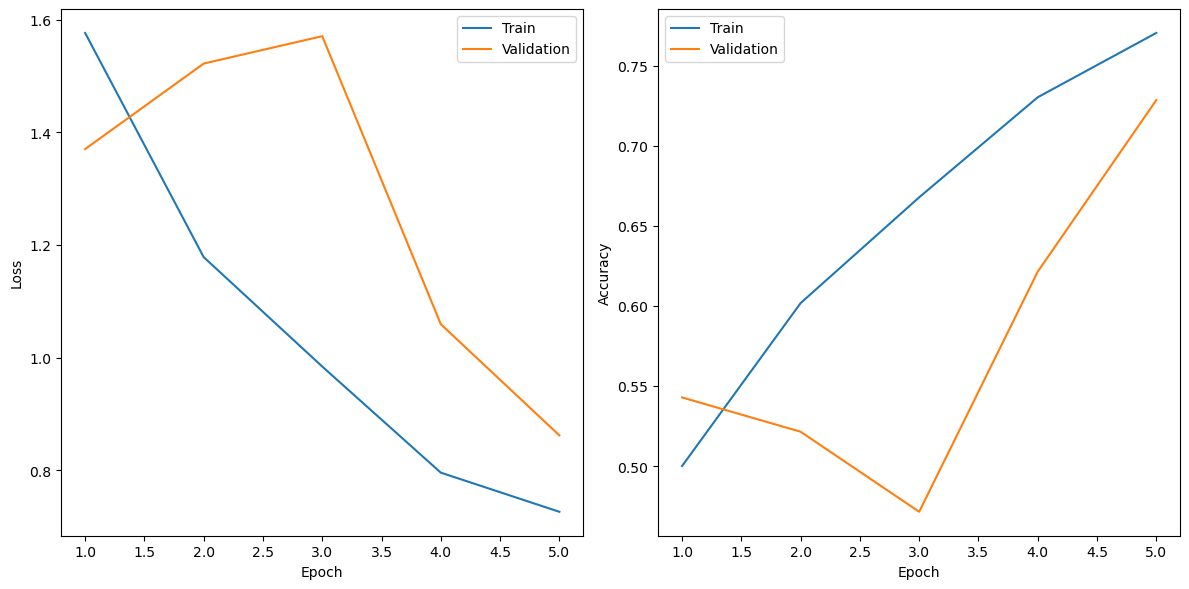

In [189]:
# Plot training and validation loss and accuracy
# Move tensors to CPU

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nb_epochs + 1), train_loss_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_loss_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, nb_epochs + 1), train_acc_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [190]:
# 모델 평가 함수 정의
def test_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on test images: {100 * correct / total}%')


In [191]:
# 훈련 및 평가
test_model(best_model, test_loader, device)

100%|██████████| 9/9 [00:00<00:00, 10.26it/s]

Accuracy of the model on test images: 63.57142857142857%
